# Importamos librerías

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Definimos metodo de carga de set

In [2]:
# convertimos un array de valores en una matriz de conjuntos de datos
def crear_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return numpy.array(dataX), numpy.array(dataY)

# Menu principal

In [3]:
if __name__ == "__main__":
    # Eliminacion de mensajes de advertencia de TensorFlow y Keras.
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    tf.logging.set_verbosity(tf.logging.ERROR)

    # Ruta del fichero con la data de entrada.
    FICHERO = 'data/international-airline-passengers.csv'
    SEED = 7

    # Fija las semillas aleatorias para la reproducibilidad.
    numpy.random.seed(SEED)

Cargamos el archivo con los datos de prueba que utilizaremos para nuestra predección, en este caso se trata de los pasajeros, en vuelos internacionales, entre los años 1949 a 1960.

In [4]:
    # Cargamos el conjunto de datos.
    dataframe = read_csv(FICHERO, usecols=[1], engine='python', skipfooter=3)
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # Normalizamos el conjunto de datos.
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Dividimos los datos entre entrenamiento y test.
    porc = 0.67                                 # Porcentaje de entrenamiento.
    size = int(len(dataset) * porc)             # Volumen de entrenamiento. 
    #test_size = len(dataset) - size            # Volumen de pruebas.
    train = dataset[0 : size , :]               # Datos de entrenamiento.
    test  = dataset[size : len(dataset) , :]    # Resto de datos para pruebas.

    # Remodelamos, X=t y Y=t+1, tanto train como test.
    look_back = 1
    trainX, trainY = crear_dataset(train, look_back)
    testX, testY = crear_dataset(test, look_back)

    # Remodelamos los datos de entrada para que sea:
    # [muestras, pasos de tiempo, características]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Creamos nuestro moledo LSTM para el entrenamiento y posteriormente la prediccion de los datos.

In [5]:
    # Creamos la Red LSTM
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Se entrena la red.
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    
    # Hacemos las predicciones.
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invertimos las predicciones.
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # Calculamos el error 
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Resultado del test: %.2f RMSE' % (testScore))

    # Predicciones del entrenamiento de cambio para plotear.
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # Predicciones del test de cambio para plotear.
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    tamTrainPredict = len(trainPredict)
    tamDataSet = len(dataset)
    testPredictPlot[tamTrainPredict+(look_back*2)+1: tamDataSet-1, :] = testPredict

Resultado del entrenamiento: 22.34 RMSE
Resultado del test: 45.66 RMSE


Nota: En caso de querer ver mas detalle de la salida en el entrenamiento de la red, colocar "verbose=True"

Finalmente se realiza el gráfico de los datos y las predecciones.

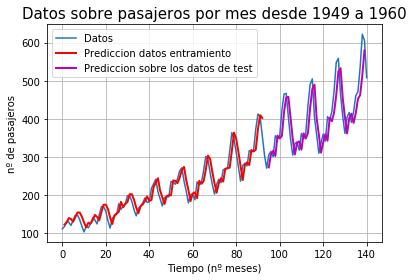

In [6]:
    # Lineabase y predicciones.
    plt.plot(scaler.inverse_transform(dataset))
    
    # ploteamos linea base y predicciones
    plt.plot(trainPredictPlot,'r', linewidth = 2)
    plt.plot(testPredictPlot,'m', linewidth = 2)
    plt.legend( ('Datos', 'Prediccion datos entramiento', 
                 'Prediccion sobre los datos de test'), loc = 'upper left')
    plt.grid(True)
    plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
    plt.xlabel("Tiempo (nº meses)", fontsize = 10)
    plt.ylabel("nº de pasajeros", fontsize = 10)
    plt.show()

En el gráfico anterior podemos ver como la linea azul, es decir, los datos de entrada, coincide con las predicciones de la red, que vendría siendo tanto la linea roja, predicciones con los datos de entrenamiento, y la linea purpura, siendo predicciones con datos de prueba.

Gráfico unicamente de los datos de predicción.

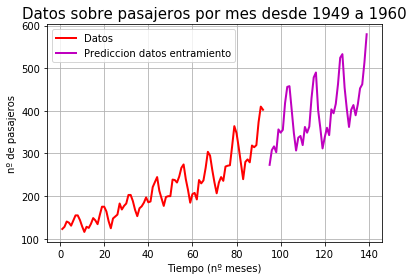

In [7]:
    # ploteamos linea base y predicciones
    plt.plot(trainPredictPlot,'r', linewidth = 2)
    plt.plot(testPredictPlot,'m', linewidth = 2)
    plt.legend( ('Datos', 'Prediccion datos entramiento', 
                 'Prediccion sobre los datos de test'), loc = 'upper left')
    plt.grid(True)
    plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
    plt.xlabel("Tiempo (nº meses)", fontsize = 10)
    plt.ylabel("nº de pasajeros", fontsize = 10)
    plt.show()